# Libraries

In [1]:
using Plots
using Random
using Distributions
using LinearAlgebra
include("pogm_restart.jl")
using ProgressMeter
using HePPCAT
using Distributed
using JLD

# HPCA KNOWN AND UNKNOWN CODE [APGD]

In [2]:
function HPCA_KNOWN(Y, λr, w, α, ϵ)
    Π = w.^-1
    Lf = maximum(Π)
    Π = Diagonal(Π)
    x0 = zeros(size(Y))
    grad = K -> -1*(Y-K)*Π
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*diagm(S)*V'
    end
    prox1 = (z,c) -> pssvt(z, c*λr, α)
    W, _ = pogm_restart(x0, x -> 0, grad, Lf ; g_prox=prox1, eps=ϵ, mom=:fpgm, restart=:gr) # objective(x,Y-x,λr,w)
    return W
end

function HPCA_APGD(Y, λr, w, N, ϵ, X0)
    Π = w.^-1
    Lf = maximum(Π)
    Π = Diagonal(Π)
    grad = K -> -1*(Y-K)*Π
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*diagm(S)*V'
    end
    prox1 = (z,c) -> pssvt(z, c*λr, N)
    K, _ = pogm_restart(X0, x -> 0, grad, Lf ; g_prox=prox1, eps=ϵ, mom=:fpgm, restart=:gr) # objective(x,Y-x,λr,w)
    return K
end

function AltMin(Y, λr, N, ϵ)
    Π = ones(size(Y)[2])
    X = zeros(size(Y))
    X = HPCA_APGD(Y, λr, Π, 0, ϵ, X)
    Π = W_NO_GROUPS(Y, X)
    X0 = zeros(size(Y)) .+ 1
    while norm(X-X0, 2)/norm(X0,2) > 1e-6
        X0 = X
        X = HPCA_APGD(Y, λr, Π, N, ϵ, X)
        Π = W_NO_GROUPS(Y, X)
    end
    return X, Π
end

function W_NO_GROUPS(Y, L)
    d = size(Y)[1]
    Π = diag((1/d)*(Y-L)'*(Y-L))
    return max.(Π, 1e-9)
end

function W_ALL_GROUPS(Y, L, goodpts)
    Π = vec(zeros(size(Y)[2],1))
    d = size(Y)[1]
    N = size(Y)[2]
    Π[1:goodpts] .= (1/(d*goodpts))*norm(Y[:,1:goodpts]-L[:,1:goodpts],2)^2
    Π[(goodpts+1):end] .= (1/(d*(N-goodpts)))*norm(Y[:,(goodpts+1):end]-L[:,(goodpts+1):end],2)^2
    return max.(Π, 1e-9)
end

W_ALL_GROUPS (generic function with 1 method)

# HPCA UNKNOWN CODE [ADMM]

In [3]:
function HPCA_UNKNOWN_ADMM(Y, λr, k, μ)
    U_init = svd(Y).U[:, 1:k]
    X = deepcopy(U_init*U_init'*Y)
    Z = deepcopy(Y-X)
    #X = zeros(size(Y))
    #Z = zeros(size(Y))
    ρ = 1.01
    var = W_NO_GROUPS(Y,X)
    Π = diagm(var.^-1)
    Λ2 = sign.(Y)
    Λ = deepcopy(Λ2 ./ (max(opnorm(Λ2), (1/λr)*norm(Λ2, Inf))))
    normY = norm(Y,2)
    count = 0
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,k)
        U,S,V = svd(x)
        S[(k+1):end] = soft.(S[(k+1):end],t)
        return U*diagm(S)*V'
    end
    while ((norm(Y-X-Z,2)/normY > 1e-7) || (count <10))
        X = pssvt(Y-Z+(1/μ)*Λ, λr/μ,k)
        Z = μ*(Y-X+(1/μ)*Λ)*inv(Π+μ*I)
        Λ = Λ + μ*(Y-X-Z)
        var = W_NO_GROUPS(Y,X)
        Π = diagm(var.^-1)
        μ = ρ*μ
        count = count + 1
    end 
    return X, var
end

HPCA_UNKNOWN_ADMM (generic function with 1 method)

# Data Generation

In [4]:
function generateSubspace(goodPoints,badPoints,dimSubspace,ambientSpace)
    #rng = Random.seed!(0)
    N = goodPoints+badPoints
    D = ambientSpace
    d = dimSubspace
    U = svd(rand(D,N)).U[:,1:d]
    return U
end

function generateTrainingData(U, ν1,ν2,goodPoints,badPoints,dimSubspace,ambientSpace)
    #rng = Random.seed!(1)
    N = goodPoints+badPoints
    D = ambientSpace
    d = dimSubspace
    window = 10
    X = U*rand(Uniform(-window,window),d,N) #U*U'*rand(Uniform(-100,100),D,N)
    Y = zeros(D,N)
    Y[:,1:goodPoints] = X[:,1:goodPoints] +  rand(Normal(0,sqrt(ν1)),D,goodPoints)
    Y[:,(goodPoints+1):end] = X[:,(goodPoints+1):end] +  rand(Normal(0,sqrt(ν2)),D,badPoints)
    return Y
end

function generateValidationData(U,ν1,ν2,goodPoints,badPoints,dimSubspace,ambientSpace)
    #rng = Random.seed!(2)
    N = goodPoints+badPoints
    D = ambientSpace
    d = dimSubspace
    window = 10
    X = U*rand(Uniform(-window,window),d,N) #U*U'*rand(Uniform(-100,100),D,N)
    Y = zeros(D,N)
    Y[:,1:goodPoints] = X[:,1:goodPoints] +  rand(Normal(0,sqrt(ν1)),D,goodPoints)
    Y[:,(goodPoints+1):end] = X[:,(goodPoints+1):end] +  rand(Normal(0,sqrt(ν2)),D,badPoints)
    return Y
end


generateValidationData (generic function with 1 method)

# HPCA/PCA (Known) Heatmaps

In [ ]:
varianceRatio = range( 1, 100,20) #20 for plot
pointRatio = range(1,100,20) # 20 points for plot
hpcaMatrix = zeros(length(varianceRatio), length(pointRatio))
ppcaMatrix = zeros(length(varianceRatio), length(pointRatio))
goodsubspaceMatrix = zeros(length(varianceRatio), length(pointRatio))

goodPoints = 10
ν1 = 1
dimSubspace = 10
ambientSpace = 100
trials = 1

@showprogress 1 "Computing..." for i = 1:length(varianceRatio) # varianceRatio
    Threads.@threads for j = 1:length(pointRatio) # pointRatio
        for k = 1:trials
            ν2 = varianceRatio[i]*ν1
            badPoints = round(Int, pointRatio[j]*goodPoints)
            U = generateSubspace(goodPoints,badPoints, dimSubspace, ambientSpace)
            #trainingData = generateTrainingData(U,ν1,ν2,goodPoints,badPoints, dimSubspace, ambientSpace)
            validationData = generateValidationData(U,ν1,ν2,goodPoints,badPoints, dimSubspace, ambientSpace)
            w = vcat(ν1*ones(goodPoints) , ν2*ones(badPoints))
            λr = 1000000 
            # HPCA
            X_hpca = HPCA_KNOWN(validationData, λr, w, dimSubspace, 1e-6)
            U_hpca = svd(X_hpca).U[:,1:dimSubspace]
            error_hpca = norm(U_hpca*U_hpca' - U*U',2)/norm(U*U',2)
            # PPCA
            U_PCA = svd(validationData).U[:,1:dimSubspace];
            error_ppca = norm(U_PCA*U_PCA' - U*U',2)/norm(U*U',2)
            # PCA GOOD POINTS ONLY
            U_good = svd(validationData[:,1:goodPoints]).U[:,1:dimSubspace];
            error_goodsubspace = norm(U_good*U_good' - U*U',2)/norm(U*U',2) 
            #temp1, temp2, temp3 = reportError(validationData, λr,dimSubspace,w,U, goodPoints)
            hpcaMatrix[i,j], ppcaMatrix[i,j], goodsubspaceMatrix[i,j] =  hpcaMatrix[i,j]+(1/trials)*error_hpca, ppcaMatrix[i,j]+(1/trials)*error_ppca, goodsubspaceMatrix[i,j]+(1/trials)*error_goodsubspace #hpcaMatrix[i,j] + (1/trials)*temp1, ppcaMatrix[i,j] + (1/trials)*temp2, goodsubspaceMatrix[i,j]+(1/trials)*temp3
        end
    end
end

Computing...  95%|██████████████████████████████████████ |  ETA: 0:00:59

In [9]:
save("knownVarianceMatrix.jld", "hpcaMatrix", hpcaMatrix, "ppcaMatrix", ppcaMatrix, "goodsubspaceMatrix", goodsubspaceMatrix)

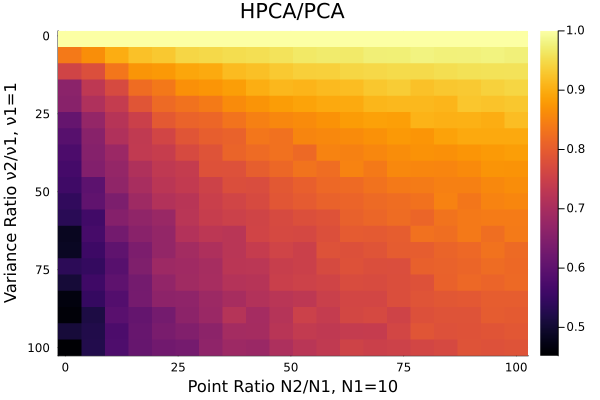

In [10]:
heatmap(pointRatio, varianceRatio, hpcaMatrix./ppcaMatrix, title="HPCA/PCA", xlabel="Point Ratio N2/N1, N1=10", ylabel="Variance Ratio ν2/ν1, ν1=1",yflip=true)
#savefig("HPCA_KNOWN_PCA_HEATMAP.pdf")

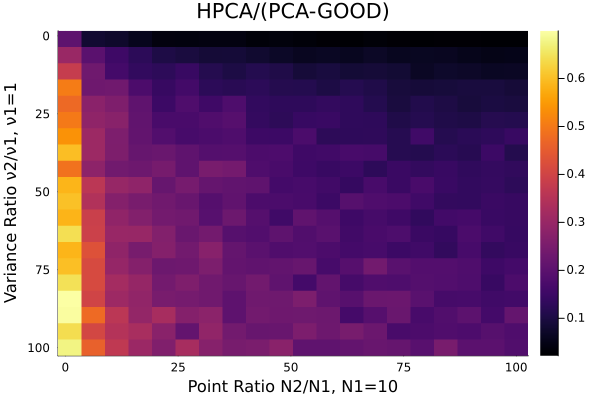

In [11]:
heatmap(pointRatio, varianceRatio, hpcaMatrix./goodsubspaceMatrix, title="HPCA/(PCA-GOOD)", xlabel="Point Ratio N2/N1, N1=10", ylabel="Variance Ratio ν2/ν1, ν1=1",yflip=true)
#savefig("HPCA_KNOWN_PCA-GOOD_HEATMAP.pdf")

# Robust PCA Code

In [13]:
function POGM_RPCA(Y, λr, ϵ)
    M,N = size(Y)
    A = hcat(Matrix(1.0I, M, N),Matrix(1.0I, M, N))
    B = vcat(A,A)
    Lf = opnorm(B)
    x0 = vcat(zeros(size(Y)),zeros(size(Y)))
    grad = K -> repeat(-1*(Y-K[1:M,:]-K[M+1:end,:]),2,1)
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function svst(x,t)
        U,S,Vt = svd(x)
        return U*diagm(soft.(S, t))*Vt'
    end
    prox1 = (z,c) -> vcat(svst(z[1:M,:], c*λr), soft(z[M+1:end,:], c))
    #prox1 = (z,c) -> vcat(svst(z[1:M,:], c), soft(z[M+1:end,:], λr*c))
    K, _ = pogm_restart(x0, x->0, grad, Lf ; g_prox=prox1, eps=ϵ, mom=:fpgm, restart=:gr)
    return K[1:M,:] #,K[M+1:end,:]  Outlier matrix
end

function ADMM_RPCA(Y, μ, λ)
    L = zeros(size(Y))
    S = zeros(size(Y))
    Λ2 = sign.(Y)
    Λ = deepcopy(Λ2 ./ (max(opnorm(Λ2), (1/λ)*norm(Λ2, Inf))))
    function soft(z, λ)     
        return sign.(z) .* max.(abs.(z) .- λ,0)
    end
    
    function svt(A,λ)
        U, σ, V = svd(A)
        return U*diagm(soft(σ,λ))*V'
    end
    
    normY = norm(Y,2)
    count = 0
    while ((norm(Y-L-S,2)/normY > 1e-7) || (count <100))
        L = svt(Y-S+(1/μ)*Λ, λ/μ)
        S = soft(Y-L+(1/μ)*Λ, 1/μ)
        Λ = Λ + μ*(Y-L-S)
        count = count + 1
    end
    return L
end

ADMM_RPCA (generic function with 1 method)

# Cross Validation Code

In [30]:
function crossValidationHPCA(U, Y, dimSubspace)
    λ = [0.01, 0.1, 1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 100, 1000]
    error = zeros(length(λ))
    count = 1
    for i in λ
        #println(i)
        #flush(stdout)
        X,Π = AltMin(Y, i, dimSubspace,1e-2)
        U_test = svd(X).U[:,1:dimSubspace]
        error[count] = norm(U_test*U_test' - U*U',2)/norm(U*U',2)
        count = count + 1
    end
    λr = λ[argmin(error)]
    return λr
end

function crossValidationHPCA_ADMM(U, Y, dimSubspace, μ)
    λ = [0.01, 0.1, 1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 100, 1000]
    error = zeros(length(λ))
    count = 1
    for i in λ
        #println(i)
        #flush(stdout)
        X, Π = HPCA_UNKNOWN_ADMM(Y, i, dimSubspace, μ)
        U_test = svd(X).U[:,1:dimSubspace]
        error[count] = norm(U_test*U_test' - U*U',2)/norm(U*U',2)
        count = count + 1
    end
    λr = λ[argmin(error)]
    return λr
end

function crossValidationRPCA(U, Y, dimSubspace)
    λ = [0.001, 0.01, 0.1, 1, 2.5, 5,7.5, 10, 12.5, 15, 50, 100]
    error = zeros(length(λ))
    count = 1
    for i in λ
        X = POGM_RPCA(Y, i, 1e-6)
        U_test = svd(X).U[:,1:dimSubspace]
        error[count] = norm(U_test*U_test' - U*U',2)/norm(U*U',2)
        count = count + 1
    end
    λr = λ[argmin(error)]
    return λr
end

function crossValidationRPCA_ADMM(U, Y, dimSubspace, μ)
    λ = [0.01, 0.1, 1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 100, 1000]
    error = zeros(length(λ))
    count = 1
    for i in λ
        X = ADMM_RPCA(Y, μ, i)
        U_test = svd(X).U[:,1:dimSubspace]
        error[count] = norm(U_test*U_test' - U*U',2)/norm(U*U',2)
        count = count + 1
    end
    λr = λ[argmin(error)]
    return λr
end

crossValidationRPCA_ADMM (generic function with 1 method)

# Robust PCA / Cross Validation Simple Check

In [22]:
crossValidationRPCA(U, trainingData, dimSubspace)

0.01

# RPCA CV MATRIX GENERATION

In [33]:
varianceRatio = range( 1, 100,20) #20 for plot
pointRatio = range(1,100,20) # 20 points for plot
lambdaMatrixRPCA = zeros(length(varianceRatio), length(pointRatio))

goodPoints = 10
ν1 = 1
dimSubspace = 10
ambientSpace = 100
trials = 1

@showprogress for i = 1:length(varianceRatio) # varianceRatio
    Threads.@threads for j = 1:length(pointRatio) # pointRatio
        for k = 1:trials
            ν2 = varianceRatio[i]*ν1
            badPoints = round(Int, pointRatio[j]*goodPoints)
            U = generateSubspace(goodPoints,badPoints, dimSubspace, ambientSpace)
            trainingData = generateTrainingData(U,ν1,ν2,goodPoints,badPoints, dimSubspace, ambientSpace)
            # cross validation
            λr = crossValidationRPCA(U, trainingData, dimSubspace) #crossValidationHPCA_ADMM(U,trainingData,dimSubspace, μ)
            lambdaMatrixRPCA[i,j] = lambdaMatrixRPCA[i,j] + (1/trials)*λr
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:57:39


In [35]:
using JLD
save("crossValidationRPCA.jld", "lambdaMatrixRPCA", lambdaMatrixRPCA)

# RPCA/PCA HEATMAP GENERATION

In [37]:
varianceRatio = range( 1, 100,20) #20 for plot
pointRatio = range(1,100,20) # 20 points for plot
hpcaMatrix = zeros(length(varianceRatio), length(pointRatio))
ppcaMatrix = zeros(length(varianceRatio), length(pointRatio))
rpcaMatrix = zeros(length(varianceRatio), length(pointRatio))

goodPoints = 10
ν1 = 1
dimSubspace = 10
ambientSpace = 100
trials = 10

@showprogress for i = 1:length(varianceRatio) # varianceRatio
    Threads.@threads for j = 1:length(pointRatio) # pointRatio
        for k = 1:trials
            ν2 = varianceRatio[i]*ν1
            badPoints = round(Int, pointRatio[j]*goodPoints)
            U = generateSubspace(goodPoints,badPoints, dimSubspace, ambientSpace)
            #trainingData = generateTrainingData(U,ν1,ν2,goodPoints,badPoints, dimSubspace, ambientSpace)
            validationData = generateValidationData(U,ν1,ν2,goodPoints,badPoints, dimSubspace, ambientSpace)
            w = vcat(ν1*ones(goodPoints) , ν2*ones(badPoints))
            # cross validation
            λr = lambdaMatrix[i,j]
            λr_RPCA = lambdaMatrixRPCA[i,j]
            # PCA
            U_PCA = svd(validationData).U[:,1:dimSubspace];
            error_ppca = norm(U_PCA*U_PCA' - U*U',2)/norm(U*U',2)
            # HPCA
            #X_hpca,_ = AltMin(validationData, λr, dimSubspace, 1e-2)
            X_hpca,_ = HPCA_UNKNOWN_ADMM(validationData, λr, dimSubspace, 0.1)
            U_hpca = svd(X_hpca).U[:,1:dimSubspace]
            error_hpca = norm(U_hpca*U_hpca' - U*U',2)/norm(U*U',2)
            # RPCA
            X_rpca = POGM_RPCA(validationData, λr_RPCA, 1e-6)
            U_RPCA = svd(X_rpca).U[:,1:dimSubspace];
            error_rpca = norm(U_RPCA*U_RPCA' - U*U', 2)/norm(U*U', 2)
            
            hpcaMatrix[i,j], ppcaMatrix[i,j], rpcaMatrix[i,j] = hpcaMatrix[i,j]+(1/trials)*error_hpca, ppcaMatrix[i,j]+(1/trials)*error_ppca, rpcaMatrix[i,j]+(1/trials)*error_rpca
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 2:03:35


In [39]:
save("unknownVarianceMatrixRPCA.jld", "hpcaMatrix", hpcaMatrix, "ppcaMatrix", ppcaMatrix, "rpcaMatrix", rpcaMatrix)

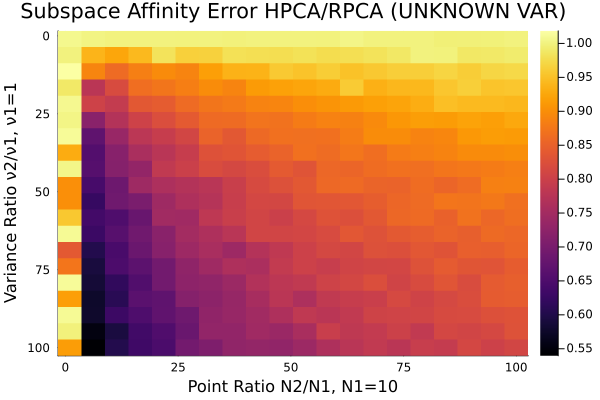

In [38]:
heatmap(pointRatio, varianceRatio, hpcaMatrix./rpcaMatrix, title="Subspace Affinity Error HPCA/RPCA (UNKNOWN VAR)", xlabel="Point Ratio N2/N1, N1=10", ylabel="Variance Ratio ν2/ν1, ν1=1",yflip=true)
#savefig("HPCA_UNKNOWN_RPCA_HEATMAP.pdf")

# HPCA CV MATRIX GENERATION

In [7]:
μ = 0.1

0.1

In [48]:
varianceRatio = range( 1, 100,20) #20 for plot
pointRatio = range(1,100,20) # 20 points for plot
lambdaMatrix = zeros(length(varianceRatio), length(pointRatio))

goodPoints = 10
ν1 = 1
dimSubspace = 10
ambientSpace = 100
trials = 1

@showprogress for i = 1:length(varianceRatio) # varianceRatio
    Threads.@threads for j = 1:length(pointRatio) # pointRatio
        for k = 1:trials
            ν2 = varianceRatio[i]*ν1
            badPoints = round(Int, pointRatio[j]*goodPoints)
            U = generateSubspace(goodPoints,badPoints, dimSubspace, ambientSpace)
            trainingData = generateTrainingData(U,ν1,ν2,goodPoints,badPoints, dimSubspace, ambientSpace)
            # cross validation
            λr = crossValidationHPCA_ADMM(U,trainingData,dimSubspace, μ)
            lambdaMatrix[i,j] = lambdaMatrix[i,j] + (1/trials)*λr
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 3:59:39


In [50]:
save("crossValidationHPCA.jld", "lambdaMatrix", lambdaMatrix)

# HPCA HEATMAP GENERATION

In [9]:
varianceRatio = range( 1, 100,20) #20 for plot
pointRatio = range(1,100,20) # 20 points for plot
hpcaMatrix = zeros(length(varianceRatio), length(pointRatio))
ppcaMatrix = zeros(length(varianceRatio), length(pointRatio))
heppcatMatrix = zeros(length(varianceRatio), length(pointRatio))

goodPoints = 10
ν1 = 1
dimSubspace = 10
ambientSpace = 100
trials = 10

@showprogress for i = 1:length(varianceRatio) # varianceRatio
    Threads.@threads for j = 1:length(pointRatio) # pointRatio
        for k = 1:trials
            ν2 = varianceRatio[i]*ν1
            badPoints = round(Int, pointRatio[j]*goodPoints)
            U = generateSubspace(goodPoints,badPoints, dimSubspace, ambientSpace)
            #trainingData = generateTrainingData(U,ν1,ν2,goodPoints,badPoints, dimSubspace, ambientSpace)
            validationData = generateValidationData(U,ν1,ν2,goodPoints,badPoints, dimSubspace, ambientSpace)
            w = vcat(ν1*ones(goodPoints) , ν2*ones(badPoints))
            # cross validation
            #λr = crossValidationHPCA_ADMM(U,trainingData,dimSubspace, μ)
            λr = lambdaMatrix[i,j]
            #println(λr)
            #flush(stdout)
            # PCA
            U_PCA = svd(validationData).U[:,1:dimSubspace];
            error_ppca = norm(U_PCA*U_PCA' - U*U',2)/norm(U*U',2)
            # HPCA
            X_hpca,_ = HPCA_UNKNOWN_ADMM(validationData, λr, dimSubspace, μ)
            #X_hpca,_ = AltMin(validationData, λr, dimSubspace, 1e-2)
            U_hpca = svd(X_hpca).U[:,1:dimSubspace]
            error_hpca = norm(U_hpca*U_hpca' - U*U',2)/norm(U*U',2)
            # HEPPCAT
            heppCAT_nogroups = []
            for k = 1:size(validationData)[2]
                push!(heppCAT_nogroups, validationData[:,k])
            end
            heppCAT_NOG = heppcat(heppCAT_nogroups, dimSubspace, 1000; varfloor=1e-9)
            error_heppcat = norm(heppCAT_NOG.U*heppCAT_NOG.U' - U*U', 2)/norm(U*U', 2)
            
            hpcaMatrix[i,j], ppcaMatrix[i,j], heppcatMatrix[i,j] = hpcaMatrix[i,j]+(1/trials)*error_hpca, ppcaMatrix[i,j]+(1/trials)*error_ppca, heppcatMatrix[i,j]+(1/trials)*error_heppcat
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 13:38:46


In [19]:
save("unknownVarianceMatrix.jld", "hpcaMatrix", hpcaMatrix, "ppcaMatrix", ppcaMatrix, "heppcatMatrix", heppcatMatrix)

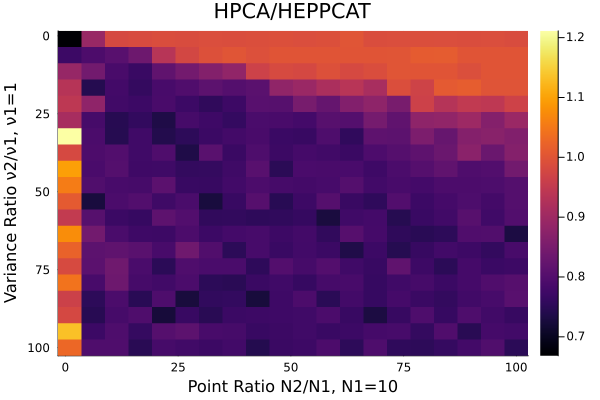

In [17]:
heatmap(pointRatio, varianceRatio, hpcaMatrix./heppcatMatrix, title="HPCA/HEPPCAT", xlabel="Point Ratio N2/N1, N1=10", ylabel="Variance Ratio ν2/ν1, ν1=1",yflip=true)
#savefig("HPCA_UNKNOWN_HEPPCAT_HEATMAP.pdf")

# Debugging Code Stuff

In [62]:
ν1 = 1
ν2 = 100
badPoints = 1000
goodPoints = 10
ambientSpace = 100
dimSubspace = 10

w = vcat(ν1*ones(goodPoints) , ν2*ones(badPoints))
U = generateSubspace(goodPoints,badPoints, dimSubspace, ambientSpace)
trainingData = generateTrainingData(U,ν1,ν2,goodPoints,badPoints, dimSubspace, ambientSpace);
validationData = generateValidationData(U,ν1,ν2,goodPoints,badPoints, dimSubspace, ambientSpace);

In [63]:
U_PCA = svd(validationData).U[:,1:dimSubspace];
error_ppca = norm(U_PCA*U_PCA' - U*U',2)/norm(U*U',2)

0.07439246642910124

In [64]:
heppCAT_nogroups = []
for k = 1:size(validationData)[2]
    push!(heppCAT_nogroups, validationData[:,k])
end
heppCAT_NOG = heppcat(heppCAT_nogroups, dimSubspace, 1000; varfloor=1e-9)
error_heppcat = norm(heppCAT_NOG.U*heppCAT_NOG.U' - U*U', 2)/norm(U*U', 2)

0.07081224525211594

In [68]:
X, var = HPCA_UNKNOWN_ADMM(validationData, 50, dimSubspace, 1)
U_hpca = svd(X).U[:,1:dimSubspace]
norm(U_hpca*U_hpca' - U*U', 2)/norm(U*U', 2)

0.05799783590080373

In [69]:
X, _ = AltMin(validationData, 50, dimSubspace, 1e-3)
U_hpca = svd(X).U[:,1:dimSubspace]
norm(U_hpca*U_hpca' - U*U', 2)/norm(U*U', 2)

0.06707381211106067